In [1]:
# import libraries
import pandas as pd
import spacy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tomotopy as tp
import gensim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
# import data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train.head()

,helpfulness_cat,imdb_user_review
0,1.0,It is hard to find such delightful and adorabl...
1,1.0,"They don't make films like this faded, hauntin..."
2,1.0,I first viewed this movie in 1924 at age 6 yrs...
3,1.0,I doubt that I'd ever seen anything resembling...
4,1.0,I was shocked to find myself riveted to this m...


In [4]:
print(sum(train['helpfulness_cat'])/len(train))

0.7637377963737796


In [5]:
document_lengths = np.array(list(map(len, train['imdb_user_review'].str.split(' '))))

print("The average number of words in a document is: {}.".format(np.mean(document_lengths)))
print("The minimum number of words in a document is: {}.".format(min(document_lengths)))
print("The maximum number of words in a document is: {}.".format(max(document_lengths)))

The average number of words in a document is: 175.48888888888888.
The minimum number of words in a document is: 6.
The maximum number of words in a document is: 3954.


/Users/crystal_wong/opt/anaconda3/envs/SMM694/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Distribution of number of words'}, xlabel='Number of words', ylabel='Density'>

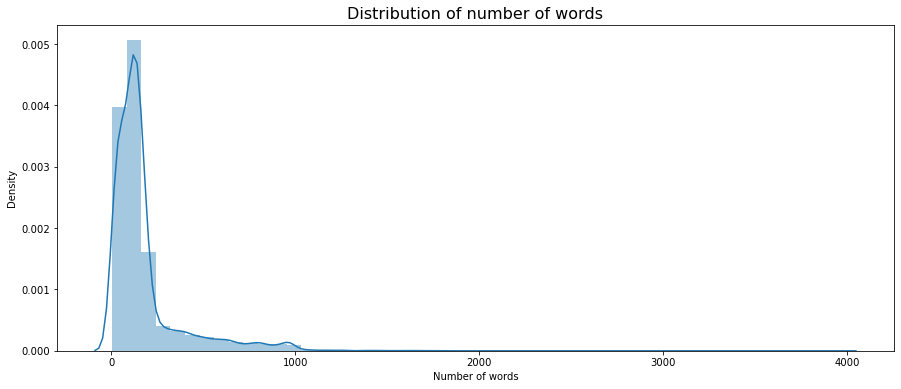

In [6]:
fig, ax = plt.subplots(figsize=(15,6))

ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(document_lengths, bins=50, ax=ax)

In [7]:
print("There are {} documents with over 1500 words.".format(sum(document_lengths > 1500)))
print("There are {} documents with max 6 words.".format(sum(document_lengths <= 6)))

There are 9 documents with over 1500 words.
There are 2 documents with max 6 words.


### Basic Data Cleansing

In [8]:
import re

In [9]:
# data sample
train['imdb_user_review'][0]

'It is hard to find such delightful and adorable movies these days as \\"The Kid\\". It is a silent movie but so rich, winning and beautiful that you don\\u00b4t nead words. Chaplin and 6-year old Coogan are possibly the most charming pair I have ever seen in my life. The film succees to be nicely light and full of joy but also overwhelmingly sad and sentimental. I always get my eyes full with tears of saddness and happiness. And I really never cry in movies. And the music...its simply Oscar-level! The movie is sympathetic, full of feeling, touchingly funny moments. It is truly a masterpiece showing how extraordinary talented person Charlie Chaplin was considering this film is respectively over 80 years old! So don\\u00b4t you miss it because of it\\u00b4s age, don\\u00b4t miss it.'

In [10]:
def basic_clean(text):
    """
    Remove \\,\n,\t,... from text
    Remove whitespace from text
    change to lowercase
    """
    
    # Replacing all the occurrences of \n,\\n,\t,\\ with a space.
    Formatted_text = text.replace('\\n', ' ').replace('\n', ' ').replace('\t',' ').replace("\'", "'").replace('"',' ')
    pattern = re.compile(r'\s+')
    Formatted_text = Formatted_text.lower()
    Formatted_text = Formatted_text.replace('\\u00b4',"'").replace('\\','')
    Without_whitespace = re.sub(pattern, ' ', Formatted_text)
    Formatted_text = Without_whitespace.replace('?', ' ? ').replace(')', ') ')
    return Formatted_text

In [11]:
# cleaning data
train['imdb_user_review'] = train['imdb_user_review'].apply(basic_clean)
train['imdb_user_review'][0]

"it is hard to find such delightful and adorable movies these days as the kid . it is a silent movie but so rich, winning and beautiful that you don't nead words. chaplin and 6-year old coogan are possibly the most charming pair i have ever seen in my life. the film succees to be nicely light and full of joy but also overwhelmingly sad and sentimental. i always get my eyes full with tears of saddness and happiness. and i really never cry in movies. and the music...its simply oscar-level! the movie is sympathetic, full of feeling, touchingly funny moments. it is truly a masterpiece showing how extraordinary talented person charlie chaplin was considering this film is respectively over 80 years old! so don't you miss it because of it's age, don't miss it."

In [14]:
train['review_length'] = np.array(list(map(len, train['imdb_user_review'].str.split(' '))))

Sentiment Analysis

In [15]:
# using roberta-large-mnli model to analyse sentiment
from transformers import pipeline
pipe = pipeline(model="roberta-large-mnli",return_all_scores=True)

Downloading:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/688 [00:00<?, ?B/s]

2022-07-15 00:19:41.053456: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Downloading:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

/Users/crystal_wong/opt/anaconda3/envs/SMM694/lib/python3.8/site-packages/transformers/pipelines/text_classification.py:89: UserWarning: `return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality
  warnings.warn(


In [16]:
CONTRADICTION = []
NEUTRAL = []
ENTAILMENT = []

for review in train['imdb_user_review']:
   try:
    temp = 0
    temp = pipe(review)[0][0]['score']
    CONTRADICTION.append(temp)

    temp = pipe(review)[0][1]['score']
    NEUTRAL.append(temp)

    temp = pipe(review)[0][2]['score']
    ENTAILMENT.append(temp)
   except:
     temp = 0
     CONTRADICTION.append(temp)
     NEUTRAL.append(temp)
     ENTAILMENT.append(temp)

Token indices sequence length is longer than the specified maximum sequence length for this model (1268 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
# combine contradiction, neutral and entailment into a data frame
train_sentiment = pd.DataFrame({'CONTRADICTION': CONTRADICTION, 'NEUTRAL': NEUTRAL, 'ENTAILMENT': ENTAILMENT})
train_sentiment.to_csv('train_sentiment.csv', index=False)

In [15]:
# load the sentiment dataframe
train_sentiment = pd.read_csv('train_sentiment.csv')

In [16]:
# combine healpfulness and sentiment into a data frame
train_sentiment['helpfulness_cat'] = train['helpfulness_cat']

In [17]:
train_sentiment.head()

,CONTRADICTION,NEUTRAL,ENTAILMENT,helpfulness_cat
0,0.301088,0.670759,0.028153,1.0
1,0.031557,0.959142,0.009301,1.0
2,0.000880,0.994948,0.004172,1.0
3,0.441404,0.545666,0.012929,1.0
4,0.083177,0.886534,0.030290,1.0


In [18]:
# get the avg score for reviews
print("The average contradiction score for unhelpful reviews is: {}.".format(np.mean(train_sentiment['CONTRADICTION'][train_sentiment['helpfulness_cat'] == 0])))
print("The average contradiction score for helpful reviews is: {}.".format(np.mean(train_sentiment['CONTRADICTION'][train_sentiment['helpfulness_cat'] == 1])))
print("The average neutral score for unhelpful reviews is: {}.".format(np.mean(train_sentiment['NEUTRAL'][train_sentiment['helpfulness_cat'] == 0])))
print("The average neutral score for helpful reviews is: {}.".format(np.mean(train_sentiment['NEUTRAL'][train_sentiment['helpfulness_cat'] == 1])))
print("The average entailment score for unhelpful reviews is: {}.".format(np.mean(train_sentiment['ENTAILMENT'][train_sentiment['helpfulness_cat'] == 0])))
print("The average entailment score for helpful reviews is: {}.".format(np.mean(train_sentiment['ENTAILMENT'][train_sentiment['helpfulness_cat'] == 1])))


The average contradiction score for unhelpful reviews is: 0.12952283451497473.
The average contradiction score for helpful reviews is: 0.1051903646365686.
The average neutral score for unhelpful reviews is: 0.7467805991370402.
The average neutral score for helpful reviews is: 0.7229228923420817.
The average entailment score for unhelpful reviews is: 0.07568397245021014.
The average entailment score for helpful reviews is: 0.05464788262122837.


/Users/crystal_wong/opt/anaconda3/envs/SMM694/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/crystal_wong/opt/anaconda3/envs/SMM694/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/crystal_wong/opt/anaconda3/envs/SMM694/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use e

Text(0.5, 0, 'Sentiment score')

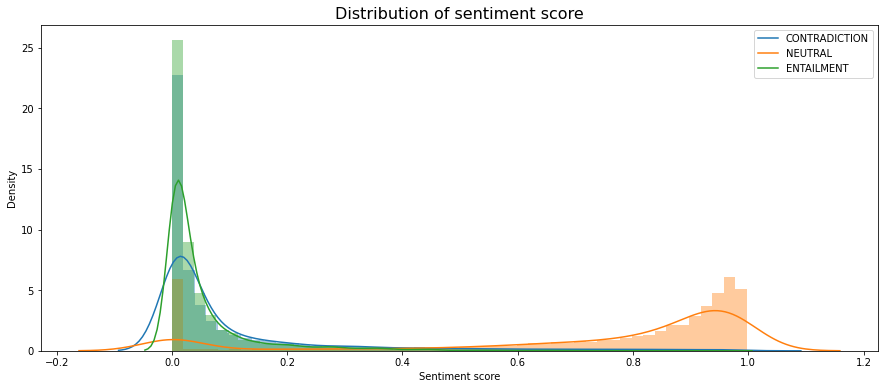

In [19]:
# plot the distribution for each sentiment score based on helpfulness_cat
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title("Distribution of sentiment score", fontsize=16)
sns.distplot(train_sentiment['CONTRADICTION'][train_sentiment['helpfulness_cat'] == 1], bins=50, ax=ax)
sns.distplot(train_sentiment['NEUTRAL'][train_sentiment['helpfulness_cat'] == 1], bins=50, ax=ax)
sns.distplot(train_sentiment['ENTAILMENT'][train_sentiment['helpfulness_cat'] == 1], bins=50, ax=ax)
# plot legend
ax.legend(['CONTRADICTION', 'NEUTRAL', 'ENTAILMENT'])
ax.set_xlabel("Sentiment score")


/Users/crystal_wong/opt/anaconda3/envs/SMM694/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/crystal_wong/opt/anaconda3/envs/SMM694/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/crystal_wong/opt/anaconda3/envs/SMM694/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use e

Text(0.5, 0, 'Sentiment score')

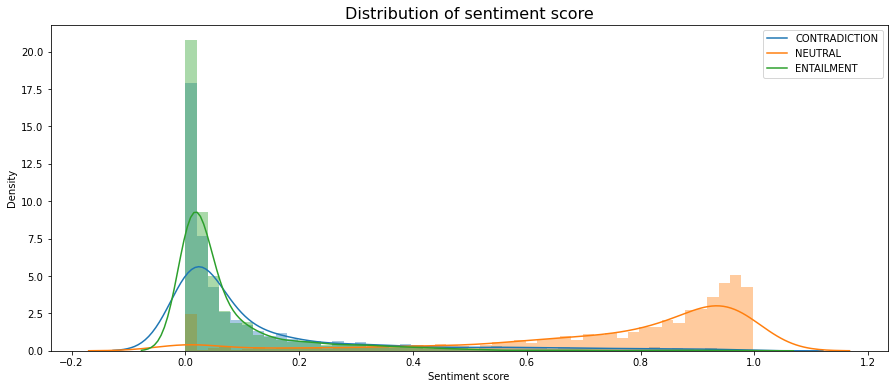

In [20]:
# plot the distribution for each sentiment score based on helpfulness_cat
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title("Distribution of sentiment score", fontsize=16)
sns.distplot(train_sentiment['CONTRADICTION'][train_sentiment['helpfulness_cat'] == 0], bins=50, ax=ax)
sns.distplot(train_sentiment['NEUTRAL'][train_sentiment['helpfulness_cat'] == 0], bins=50, ax=ax)
sns.distplot(train_sentiment['ENTAILMENT'][train_sentiment['helpfulness_cat'] == 0], bins=50, ax=ax)
# plot legend
ax.legend(['CONTRADICTION', 'NEUTRAL', 'ENTAILMENT'])
ax.set_xlabel("Sentiment score")

In [21]:
# using nltk vader to carry out sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [22]:
# create a function to calculate the sentiment score
sent_analyzer = SentimentIntensityAnalyzer()
def sentiment_score(text):
    score = sent_analyzer.polarity_scores(text)
    score.pop('compound')
    return score

In [23]:
# calculate the sentiment score for each review and create neg, neu and pos columns
train['neg'] = train['imdb_user_review'].apply(sentiment_score).apply(lambda x: x['neg'])
train['neu'] = train['imdb_user_review'].apply(sentiment_score).apply(lambda x: x['neu'])
train['pos'] = train['imdb_user_review'].apply(sentiment_score).apply(lambda x: x['pos'])
train.head()


,helpfulness_cat,imdb_user_review,review_length,neg,neu,pos
0,1.0,it is hard to find such delightful and adorabl...,135,0.049,0.542,0.410
1,1.0,"they don't make films like this faded, hauntin...",372,0.086,0.855,0.059
2,1.0,i first viewed this movie in 1924 at age 6 yrs...,53,0.045,0.749,0.206
3,1.0,i doubt that i'd ever seen anything resembling...,169,0.115,0.751,0.134
4,1.0,i was shocked to find myself riveted to this m...,122,0.058,0.797,0.145


In [24]:
# export the sentiment score to csv
train.to_csv('train_pos_neg_sentiment_score.csv', index=False)

In [25]:
# get the avg score for reviews
print("The average negative score for unhelpful reviews is: {}.".format(np.mean(train['neg'][train['helpfulness_cat'] == 0])))
print("The average negative score for helpful reviews is: {}.".format(np.mean(train['neg'][train['helpfulness_cat'] == 1])))
print("The average neutral score for unhelpful reviews is: {}.".format(np.mean(train['neu'][train['helpfulness_cat'] == 0])))
print("The average neutral score for helpful reviews is: {}.".format(np.mean(train['neu'][train['helpfulness_cat'] == 1])))
print("The average positive score for unhelpful reviews is: {}.".format(np.mean(train['pos'][train['helpfulness_cat'] == 0])))
print("The average positive score for helpful reviews is: {}.".format(np.mean(train['pos'][train['helpfulness_cat'] == 1])))


The average negative score for unhelpful reviews is: 0.11817040535222353.
The average negative score for helpful reviews is: 0.09222303384465548.
The average neutral score for unhelpful reviews is: 0.7283919716646989.
The average neutral score for helpful reviews is: 0.7369681032383735.
The average positive score for unhelpful reviews is: 0.1534478551751279.
The average positive score for helpful reviews is: 0.1708052106160214.


/Users/crystal_wong/opt/anaconda3/envs/SMM694/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/crystal_wong/opt/anaconda3/envs/SMM694/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/crystal_wong/opt/anaconda3/envs/SMM694/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use e

Text(0.5, 0, 'Sentiment score')

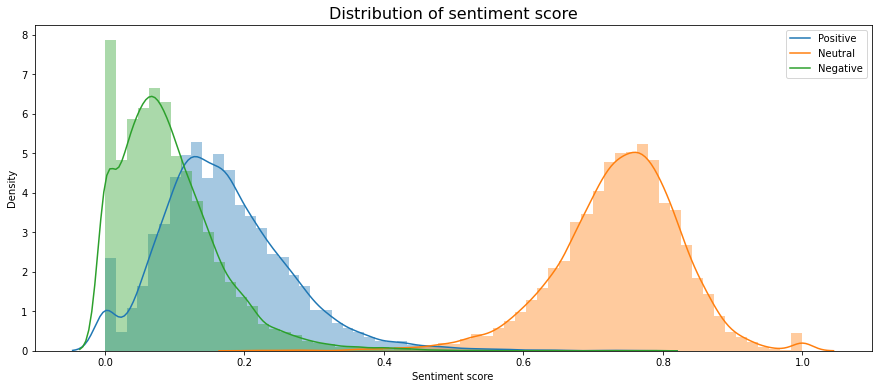

In [26]:
# plot the distribution for each sentiment score based on helpfulness_cat
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title("Distribution of sentiment score", fontsize=16)
sns.distplot(train['pos'][train['helpfulness_cat'] == 1], bins=50, ax=ax)
sns.distplot(train['neu'][train['helpfulness_cat'] == 1], bins=50, ax=ax)
sns.distplot(train['neg'][train['helpfulness_cat'] == 1], bins=50, ax=ax)
# plot legend
ax.legend(['Positive', 'Neutral', 'Negative'])
ax.set_xlabel("Sentiment score")


/Users/crystal_wong/opt/anaconda3/envs/SMM694/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/crystal_wong/opt/anaconda3/envs/SMM694/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/crystal_wong/opt/anaconda3/envs/SMM694/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use e

Text(0.5, 0, 'Sentiment score')

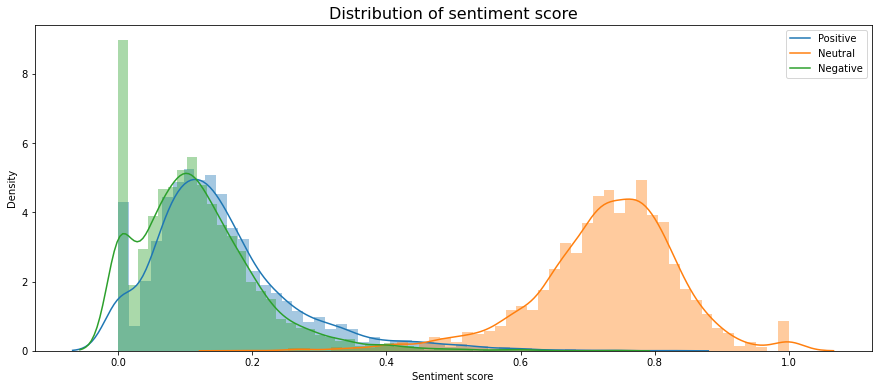

In [27]:
# plot the distribution for each sentiment score based on helpfulness_cat
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title("Distribution of sentiment score", fontsize=16)
sns.distplot(train['pos'][train['helpfulness_cat'] == 0], bins=50, ax=ax)
sns.distplot(train['neu'][train['helpfulness_cat'] == 0], bins=50, ax=ax)
sns.distplot(train['neg'][train['helpfulness_cat'] == 0], bins=50, ax=ax)
# plot legend
ax.legend(['Positive', 'Neutral', 'Negative'])
ax.set_xlabel("Sentiment score")

In [28]:
# get subjectivity score for each review
from textblob import TextBlob
def getSubjectivity(text):
   return TextBlob(text).sentiment.subjectivity

train['subjective_score'] = train['imdb_user_review'].apply(getSubjectivity)
train.head()

,helpfulness_cat,imdb_user_review,review_length,neg,neu,pos,subjective_score
0,1.0,it is hard to find such delightful and adorabl...,135,0.049,0.542,0.410,0.637457
1,1.0,"they don't make films like this faded, hauntin...",372,0.086,0.855,0.059,0.376882
2,1.0,i first viewed this movie in 1924 at age 6 yrs...,53,0.045,0.749,0.206,0.601871
3,1.0,i doubt that i'd ever seen anything resembling...,169,0.115,0.751,0.134,0.588847
4,1.0,i was shocked to find myself riveted to this m...,122,0.058,0.797,0.145,0.409792


/Users/crystal_wong/opt/anaconda3/envs/SMM694/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/crystal_wong/opt/anaconda3/envs/SMM694/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Subjectivity score')

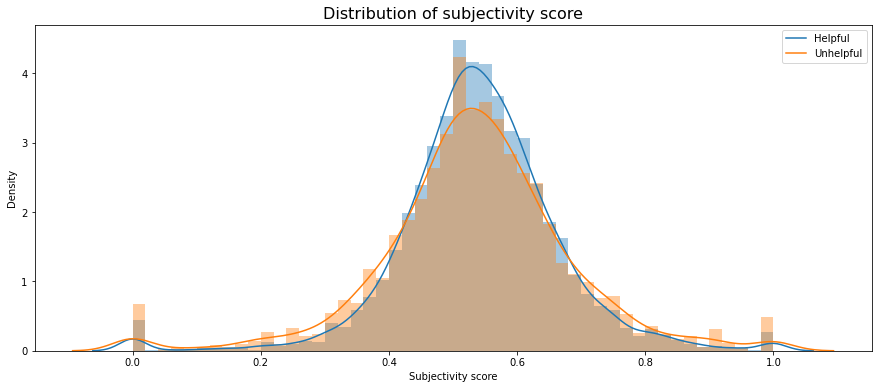

In [29]:
# plot the distribution for subjectivity score based on helpfulness_cat
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title("Distribution of subjectivity score", fontsize=16)
sns.distplot(train['subjective_score'][train['helpfulness_cat'] == 1], bins=50, ax=ax)
sns.distplot(train['subjective_score'][train['helpfulness_cat'] == 0], bins=50, ax=ax)
# plot legend
ax.legend(['Helpful', 'Unhelpful'])
ax.set_xlabel("Subjectivity score")

In [30]:
# get the avg score for reviews
print("The average subjectivity score for unhelpful reviews is: {}.".format(np.mean(train['subjective_score'][train['helpfulness_cat'] == 0])))
print("The average subjectivity score for helpful reviews is: {}.".format(np.mean(train['subjective_score'][train['helpfulness_cat'] == 1])))


The average subjectivity score for unhelpful reviews is: 0.5353938612381375.
The average subjectivity score for helpful reviews is: 0.540961413301057.


In [31]:
len(train)

10755

### LDA

In [32]:
nlp = spacy.load("en_core_web_lg")
docs = nlp.pipe(
    train.loc[:, "imdb_user_review"].str.lower(),
    n_process=2, 
    batch_size=500, 
    disable=["tok2vec"],
)
tkns_docs = []
for doc in docs:
    tmp = []
    for token in doc:
        if (
            token.is_stop == False
            and token.is_punct == False
            and token.like_num == False
            and token.is_space == False
            and token.is_oov == False
        ):
            tmp.append(token.lemma_)
    tkns_docs.append(tmp)
    del tmp

In [33]:
# identify bigram and trigram
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS

In [34]:
# Build the bigram and trigram models
bigram = Phrases(tkns_docs, min_count=5, threshold=45, connector_words=ENGLISH_CONNECTOR_WORDS) # higher threshold fewer phrases.
trigram = Phrases(bigram[tkns_docs], threshold=20, connector_words=ENGLISH_CONNECTOR_WORDS)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[tkns_docs[675]]])

['certainly', 'better', 'adaptations', 'stephen_king', 'tale', 'children', 'corn', 'goosebump', 'film', 'chilling', 'unseen', 'evil', 'force', 'group', 'murderous', 'children', 'happily', 'calls', 'walks', 'rows', 'rows', 'meaning', 'rows', 'corn', 'corn', 'field', 'image', 'walks', 'rows', 'character', 'simply', 'satan', 'new', 'nick', 'old', 'lucifer', 'chosen', 'possess', 'ears', 'corn', 'nebraska', 'instead', 'john', 'deere', 'tractor', 'sitting', 'alongside', 'reason', 'fact', 'cornfield', 'gave', 'chills', 'film', 'chills', 'watching', 'children', 'killing', 'rampage', 'small_town', 'age', 'quickly', 'laid', 'rest', 'beginning', 'film', 'kid', 'turn', 'happily', 'sacrificed', 'walks', 'rows', 'film', 'stars', 'peter', 'horton', 'linda', 'terminator', 'hamilton', 'accident', 'enter', 'small_town', 'towns', 'grown_ups', 'spotted', 'quickly', 'labeled', 'outlanders', 'pursued', 'remainder', 'film', 'finally', 'caught', 'bound', 'prepared', 'love', 'film', 'special', 'place', 'heart'

In [35]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [36]:
# form bigrams
tkns_docs = make_bigrams(tkns_docs)
# form trigrams
tkns_docs = make_trigrams(tkns_docs)

In [37]:
corpus = tp.utils.Corpus()
for item in tkns_docs:
    corpus.add_doc(words=item)
mf = {}
for i in range(20, 260, 20):
    print(
        ">>> Working on the model with {} topics >>>\n".format(i),
        flush=True
    )
    mdl = tp.LDAModel(k=i, corpus=corpus, min_df=5, rm_top=5, seed=42)
    mdl.train(0)
    for j in range(0, 700, 10):
        mdl.train(10)
        print("Iteration: {}\tLog-likelihood: {}".format(j, mdl.ll_per_word))
    coh = tp.coherence.Coherence(mdl, coherence="u_mass")
    mf[i] = coh.get_score()
    mdl.save("k_{}".format(i), True)

>>> Working on the model with 20 topics >>>

Iteration: 0	Log-likelihood: -9.988769710113742
Iteration: 10	Log-likelihood: -9.706969466875398
Iteration: 20	Log-likelihood: -9.543396152009171
Iteration: 30	Log-likelihood: -9.437237789478488
Iteration: 40	Log-likelihood: -9.367610604979836
Iteration: 50	Log-likelihood: -9.316474769374935
Iteration: 60	Log-likelihood: -9.277039095488165
Iteration: 70	Log-likelihood: -9.245271828989894
Iteration: 80	Log-likelihood: -9.219497551512665
Iteration: 90	Log-likelihood: -9.197878614168319
Iteration: 100	Log-likelihood: -9.187249161336844
Iteration: 110	Log-likelihood: -9.171536634342075
Iteration: 120	Log-likelihood: -9.154105418442379
Iteration: 130	Log-likelihood: -9.138549575714672
Iteration: 140	Log-likelihood: -9.134722700057138
Iteration: 150	Log-likelihood: -9.129297028910756
Iteration: 160	Log-likelihood: -9.121562883445756
Iteration: 170	Log-likelihood: -9.111764992122437
Iteration: 180	Log-likelihood: -9.106421332524496
Iteration: 190	L

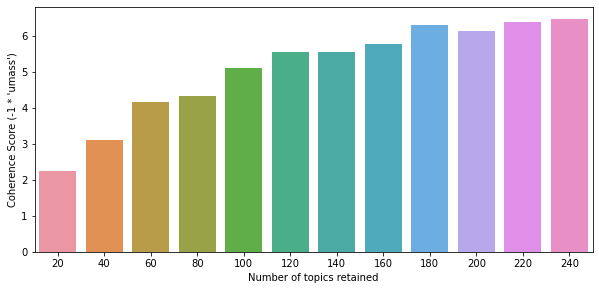

In [38]:
fig = plt.figure(figsize=(10, 4.5))
ax = fig.add_subplot(111)
sns.barplot(x=list(mf.keys()), y=[-1*score for score in mf.values()], ax=ax)
ax.set_xlabel("Number of topics retained")
ax.set_ylabel("Coherence Score (-1 * 'umass')")
plt.show()

In [37]:
best_mdl = tp.LDAModel.load("k_180")                             # step 1
td = pd.DataFrame(                                                # step 2
    np.stack([doc.get_topic_dist() for doc in best_mdl.docs]),
    columns=["topic_{}".format(i + 1) for i in range(best_mdl.k)],
)
td.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10755 entries, 0 to 10754
Data columns (total 180 columns):
 #    Column     Non-Null Count  Dtype  
---   ------     --------------  -----  
 0    topic_1    10755 non-null  float32
 1    topic_2    10755 non-null  float32
 2    topic_3    10755 non-null  float32
 3    topic_4    10755 non-null  float32
 4    topic_5    10755 non-null  float32
 5    topic_6    10755 non-null  float32
 6    topic_7    10755 non-null  float32
 7    topic_8    10755 non-null  float32
 8    topic_9    10755 non-null  float32
 9    topic_10   10755 non-null  float32
 10   topic_11   10755 non-null  float32
 11   topic_12   10755 non-null  float32
 12   topic_13   10755 non-null  float32
 13   topic_14   10755 non-null  float32
 14   topic_15   10755 non-null  float32
 15   topic_16   10755 non-null  float32
 16   topic_17   10755 non-null  float32
 17   topic_18   10755 non-null  float32
 18   topic_19   10755 non-null  float32
 19   topic_20   10755 non-nu

/var/folders/w3/c05dgb3x27z96j4wrkrgvn380000gn/T/ipykernel_47747/473627744.py:6: FutureWarning: null_counts is deprecated. Use show_counts instead
  td.info(verbose=True, null_counts=True)


In [38]:
from rich.console import Console
from rich.table import Table

In [39]:
# inspect the output of the LDA algorithm

# create a Rich's table to print the output of the spaCy's pipeline
console = Console()
# defin table properties
table = Table(
    show_header=True,
    header_style="cyan",
    title="[bold] [cyan] Word to topic probabilities (top 10 words)[/cyan]",
    width=150,
)
# add columns
table.add_column("Topic", justify="center", style="cyan", width=10)
table.add_column("W 1", width=12)
table.add_column("W 2", width=12)
table.add_column("W 3", width=12)
table.add_column("W 4", width=12)
table.add_column("W 5", width=12)
table.add_column("W 6", width=12)
table.add_column("W 7", width=12)
table.add_column("W 8", width=12)
table.add_column("W 9", width=12)
table.add_column("W 10", width=12)
# add rows
for k in range(best_mdl.k):
    values = []
    for word, prob in best_mdl.get_topic_words(k):
        values.append("{}\n({})\n".format(word, str(np.round(prob, 3))))       
    table.add_row(
        str(k),
        values[0],
        values[1],
        values[2],
        values[3],
        values[4],
        values[5],
        values[6],
        values[7],
        values[8],
        values[9],
    )
# print the table
table

                                                       Word to topic probabilities (top 10 words)                                                     
┏━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃   Topic   ┃ W 1         ┃ W 2         ┃ W 3         ┃ W 4         ┃ W 5        ┃ W 6         ┃ W 7        ┃ W 8         ┃ W 9        ┃ W 10        ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│     0     │ bella       │ edward      │ vampire     │ twilight    │ vampires   │ jacob       │ love       │ series      │ books      │ kristen_st… │
│           │ (0.068)     │ (0.054)     │ (0.046)     │ (0.04)      │ (0.032)    │ (0.027)     │ (0.019)    │ (0.016)     │ (0.014)    │ (0.011)     │
│           │             │             │             │             │            │             │            │             │            │             │
│     1     │ meryl_stre… │ character   │ real_life   │ extraordin… │ famous     │ ends        │ jim        │ circumstan… │ drive      │ julia       │
│           │ (0.024)     │ (0.021)     │ (0.019)     │ (0.017)     │ (0.015)    │ (0.014)     │ (0.012)    │ (0.012)     │ (0.012)    │ (0.012)     │
│           │             │             │             │             │            │             │            │             │            │             │
│     2     │ star_wars   │ new         │ luke        │ force       │ rey        │ disney      │ jedi       │ finn        │ episode    │ leia        │
│           │ (0.062)     │ (0.027)     │ (0.025)     │ (0.024)     │ (0.024)    │ (0.022)     │ (0.022)    │ (0.014)     │ (0.013)    │ (0.011)     │
│           │             │             │             │             │            │             │            │             │            │             │
│     3     │ team        │ head        │ virus       │ fly         │ scientist  │ cure        │ helicopter │ bridge      │ building   │ titan       │
│           │ (0.022)     │ (0.021)     │ (0.019)     │ (0.018)     │ (0.018)    │ (0.018)     │ (0.014)    │ (0.013)     │ (0.012)    │ (0.012)     │
│           │             │             │             │             │            │             │            │             │            │             │
│     4     │ series      │ better      │ level       │ plot        │ fan        │ cgi         │ cartoon    │ best        │ franchise  │ 3d          │
│           │ (0.067)     │ (0.031)     │ (0.023)     │ (0.023)     │ (0.022)    │ (0.018)     │ (0.016)    │ (0.014)     │ (0.014)    │ (0.013)     │
│           │             │             │             │             │            │             │            │             │            │             │
│     5     │ lady        │ past        │ little      │ old         │ takes      │ grand       │ star       │ begin       │ blind      │ green       │
│           │ (0.034)     │ (0.031)     │ (0.03)      │ (0.024)     │ (0.021)    │ (0.014)     │ (0.013)    │ (0.012)     │ (0.012)    │ (0.011)     │
│           │             │             │             │             │            │             │            │             │            │             │
│     6     │ bad         │ worst       │ stupid      │ boring      │ plot       │ ridiculous  │ worse      │ movies      │ terrible   │ mean        │
│           │ (0.041)     │ (0.025)     │ (0.02)      │ (0.018)     │ (0.015)    │ (0.013)     │ (0.012)    │ (0.011)     │ (0.011)    │ (0.011)     │
│           │             │             │             │             │            │             │            │             │            │             │
│     7     │ way         │ better      │ bit         │ lot         │ little     │ characters  │ gets       │ big         │ feel       │ real        │
│           │ (0.038)     │ (0.028)     │ (0.024)     │ (0.022)     │ (0.0

In [40]:
#Creating Topic Distance Visualization 
import pyLDAvis
topic_term_dists = np.stack(                                 # step 1
    [best_mdl.get_topic_word_dist(k) for k in range(best_mdl.k)]
)
doc_topic_dists = np.stack(                                  # step 2
    [doc.get_topic_dist() for doc in best_mdl.docs]
)
doc_topic_dists /= doc_topic_dists.sum(axis=1, keepdims=True)
doc_lengths = np.array([len(doc.words) for doc in best_mdl.docs]) # step 3
vocab = list(best_mdl.used_vocabs)                                # step 4
term_frequency = best_mdl.used_vocab_freq                         # step 5

In [41]:
prepared_data = pyLDAvis.prepare(
        topic_term_dists, 
        doc_topic_dists, 
        doc_lengths, 
        vocab, 
        term_frequency,
        start_index=0, 
        sort_topics=False 
    )

/Users/crystal_wong/opt/anaconda3/envs/SMM694/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/crystal_wong/opt/anaconda3/envs/SMM694/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/crystal_wong/opt/anaconda3/envs/SMM694/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/crystal_wong/opt/anaconda3/envs/SMM694/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alterna

In [42]:
pyLDAvis.display(prepared_data)

In [43]:
pyLDAvis.save_html(prepared_data, 'ldavis.html')

In [44]:
# combine the LDA result with sentiment analysis
scaler = MinMaxScaler()
# Scale values by row
td_scaled = pd.DataFrame(scaler.fit_transform(td.T).T, columns=td.columns)
# merge with train dataframe
train = pd.merge(train, td_scaled, left_index = True, right_index = True)

In [45]:
train

,helpfulness_cat,imdb_user_review,review_length,neg,neu,pos,subjective_score,topic_1,topic_2,topic_3,...,topic_171,topic_172,topic_173,topic_174,topic_175,topic_176,topic_177,topic_178,topic_179,topic_180
0,1.0,it is hard to find such delightful and adorabl...,135,0.049,0.542,0.410,0.637457,0.000887,0.000519,0.001054,...,0.002101,0.0,0.031834,0.000960,0.901466,0.000623,0.006927,0.009168,0.000397,0.000343
1,1.0,"they don't make films like this faded, hauntin...",372,0.086,0.855,0.059,0.376882,0.000581,0.000340,0.000690,...,0.001376,0.0,0.137425,0.000629,0.007243,0.000408,0.004535,0.006002,0.000260,0.000224
2,1.0,i first viewed this movie in 1924 at age 6 yrs...,53,0.045,0.749,0.206,0.601871,0.001899,0.001111,0.002257,...,0.004499,0.0,0.449459,0.002056,0.023688,0.001333,0.014831,0.019629,0.000850,0.000734
3,1.0,i doubt that i'd ever seen anything resembling...,169,0.115,0.751,0.134,0.588847,0.001098,0.000642,0.001305,...,0.002602,0.0,0.039423,0.001189,0.013700,0.221301,0.008578,0.011353,0.000491,0.000424
4,1.0,i was shocked to find myself riveted to this m...,122,0.058,0.797,0.145,0.409792,0.001237,0.000723,0.001470,...,0.002931,0.0,0.044398,0.001339,0.015429,0.000868,0.009661,0.012786,0.000553,0.000478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10750,0.0,the makers of this movie really touched a sore...,122,0.086,0.782,0.131,0.438462,0.001971,0.001153,0.002343,...,0.004670,0.0,0.070743,0.002134,0.024585,0.001384,0.015393,0.020373,0.000882,0.000762
10751,0.0,i care a lot is an exhilarating black comedy w...,44,0.031,0.728,0.241,0.777778,0.002926,0.001711,0.003478,...,0.006933,0.0,0.986351,0.003169,0.036501,0.002054,0.022854,0.030247,0.001309,0.001131
10752,0.0,really loved this. this film is masterful in t...,31,0.000,0.788,0.212,0.675000,0.004334,0.002535,0.005152,...,0.010270,0.0,0.590777,0.004694,0.924442,0.003043,0.033855,0.044808,0.001940,0.001675
10753,0.0,"the story, direction and acting across the boa...",25,0.000,0.744,0.256,0.675000,0.003099,0.001813,0.314814,...,0.629604,0.0,0.111238,0.003356,0.038658,0.002175,0.024204,0.032035,0.001387,0.001197


In [104]:
# split data between train and testing sets
X, y = train.drop(columns = ['helpfulness_cat']), train.loc[:, "helpfulness_cat"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

X_doc2vec_train, X_doc2vec_test = X_train['imdb_user_review'], X_test['imdb_user_review']
y_doc2vec_train, y_doc2vec_test = y_train, y_test

# create a balanced training set to training the model
train_df = pd.merge(y_train, X_train, left_index = True, right_index = True)
train_unhelpful = train_df.loc[train_df["helpfulness_cat"] == 0, :]
train_helpful = train_df.loc[train_df["helpfulness_cat"] == 1, :]
train_helpful = train_helpful.sample(n=len(train_unhelpful), random_state=42)
s = pd.concat([train_unhelpful, train_helpful])
X_train, y_train = s.iloc[:,2:].values, s.loc[:, "helpfulness_cat"].values
X_test = X_test.drop(columns = ['imdb_user_review']).values

# create a balanced training set to training the model
train_doc2vec_df = pd.merge(y_doc2vec_train, X_doc2vec_train, left_index = True, right_index = True)
train_doc2vec_unhelpful = train_doc2vec_df.loc[train_doc2vec_df["helpfulness_cat"] == 0, :]
train_doc2vec_helpful = train_doc2vec_df.loc[train_doc2vec_df["helpfulness_cat"] == 1, :]
train_doc2vec_helpful = train_doc2vec_helpful.sample(n=len(train_doc2vec_unhelpful), random_state=42)
s_doc2vec = pd.concat([train_doc2vec_unhelpful, train_doc2vec_helpful])
X_doc2vec_train, y_doc2vec_train = s_doc2vec['imdb_user_review'], s_doc2vec.loc[:, "helpfulness_cat"]

In [47]:
####### Phrase modelling + Doc2Vec ######
#import Doc2vec libraries
from nltk.tokenize import wordpunct_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.phrases import Phrases, Phraser

In [48]:
# Build bigram model to detect frequently used phrases of two words

#tokenise the reviews
tokenized_whole = [t.split() for t in train['imdb_user_review'].to_list()]
phrases_whole = Phrases(tokenized_whole, min_count=5, threshold=45)
#build the bigram model with the whole train dataset
bigram = Phraser(phrases_whole)

In [49]:
# transform the whole document with the bigram model
tkn_quotes = [wordpunct_tokenize(quote.lower()) for quote in train['imdb_user_review'].to_list()] 
tkn_quotes_bigram = bigram[tkn_quotes]
tgd_quotes= [TaggedDocument(d, [i]) for i, d in enumerate(tkn_quotes_bigram)]


In [50]:
# Doc2Vec with distributed memory approach - use the whole dataset to fit the model
model_dm = Doc2Vec(
    tgd_quotes, dm = 1, dm_mean = 1,
    vector_size=100, window=2, min_count=1, 
    epochs=100,negative=5
    )

In [51]:
# transform the train document with the bigram model
tkn_quotes_train = [wordpunct_tokenize(quote.lower()) for quote in X_doc2vec_train.to_list()] 
tkn_quotes_train_bigram = bigram[tkn_quotes_train]
tgd_quotes_train= [TaggedDocument(d, [i]) for i, d in enumerate(tkn_quotes_train_bigram)]


In [52]:
# transform the test document with the bigram model
tkn_quotes_test = [wordpunct_tokenize(quote.lower()) for quote in X_doc2vec_test.to_list()] 
tkn_quotes_test_bigram = bigram[tkn_quotes_test]
tgd_quotes_test= [TaggedDocument(d, [i]) for i, d in enumerate(tkn_quotes_test_bigram)]


In [53]:
from sklearn.metrics import classification_report

In [54]:
#vectorise the train and test dataset
dm_vectors_train  = [model_dm.infer_vector(tgd_quotes_train[i].words) 
                        for i in range(len(tgd_quotes_train))]

dm_vectors_test  = [model_dm.infer_vector(tgd_quotes_test[i].words) 
                        for i in range(len(tgd_quotes_test))]

In [55]:
pd.DataFrame(dm_vectors_train)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.438866,0.048045,-0.830289,0.383570,-0.892478,-0.134830,0.126595,-0.542994,-2.209658,-1.516592,...,-0.584320,1.195487,-0.167583,-0.256455,1.152528,-0.765493,0.690888,-1.195109,1.495058,-0.359768
1,-1.532405,1.200519,-0.852309,0.194129,-1.398178,-0.639709,-0.869227,1.663511,0.482216,-0.314251,...,-0.384038,1.155260,-0.374296,0.330015,1.806248,-0.810791,-0.864019,-2.500656,-0.339533,-0.611683
2,-2.540173,-0.275569,-1.046862,-3.415463,-0.281076,-1.397928,0.981878,0.778432,-1.052223,-3.114438,...,-2.093389,0.975580,0.797935,-2.370647,0.768600,-1.693747,1.592430,-1.319734,1.242677,0.360685
3,-0.830874,0.627763,-1.517175,-0.941065,-0.172288,-0.328971,0.088154,-0.303702,-0.130576,-1.691270,...,-0.415358,0.483066,0.545210,-1.173362,0.719360,-0.559878,0.234466,-0.592229,0.239866,0.099302
4,-1.999589,-0.804339,0.746565,-0.966396,0.030885,-0.175937,0.468534,3.063939,-1.228680,-1.656818,...,3.773146,0.094077,0.267874,-1.561570,-0.362718,-0.632656,-0.366394,-1.711070,1.796328,-0.506862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3553,1.313489,-0.273976,-0.457736,-0.213196,-1.002383,0.517597,-2.794856,-0.498876,-1.169252,-0.282707,...,-0.789923,-0.005562,0.262497,-3.741446,0.593742,0.671279,-0.307095,-0.355922,1.312567,0.130181
3554,-0.678182,-0.190938,-0.182935,0.377760,0.062931,0.122410,-0.636480,1.529698,-1.733271,-0.306431,...,0.052103,0.879697,0.792207,0.561072,-0.492222,-0.271490,1.274940,-0.929610,0.069123,0.218509
3555,0.405889,0.180618,-0.845098,-0.620919,-0.975342,-0.310269,-1.225514,2.222709,-2.209507,-0.596916,...,-0.179537,-0.899271,-0.578911,-0.693773,2.434113,2.090411,-1.320840,-1.104946,0.768041,-1.109648
3556,-1.039692,-0.557584,-0.456893,-0.883983,2.124271,0.949402,0.825711,1.122964,-0.015789,-0.551342,...,0.638468,2.254268,1.533941,-0.434608,2.091081,2.741645,-0.118530,-0.553367,0.990705,-1.664517


In [87]:
# combine with original dataframe
X_train_combined = np.concatenate((X_train, dm_vectors_train), axis = 1)
X_test_combined = np.concatenate((X_test, dm_vectors_test), axis = 1)


In [68]:
# scale variables
def scale_variables(x):
    df = pd.DataFrame(x)
    df = scaler.fit_transform(df)
    return df

In [88]:
X_train_combined = scale_variables(X_train_combined)
X_test_combined = scale_variables(X_test_combined)

print(X_train_combined.shape)
print(X_test_combined.shape)


(3558, 285)
(3227, 285)


In [92]:
from sklearn.linear_model import RidgeClassifier
ridge_c = RidgeClassifier(alpha=0.1, random_state=0, fit_intercept=False)
ridge_c.fit(X_train_combined, y_train)
ridge_c.score(X_test_combined, y_test)
y_pred = ridge_c.predict(X_test_combined)

In [93]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.41      0.62      0.49       762
         1.0       0.86      0.72      0.79      2465

    accuracy                           0.70      3227
   macro avg       0.63      0.67      0.64      3227
weighted avg       0.75      0.70      0.72      3227



In [94]:
# get the f-1 score
from sklearn.metrics import f1_score
f1_score = f1_score(y_test, y_pred)
f1_score

0.7856356025556289

# model build

### naive bayesian classifier

In [95]:
# build naive bayesian classifier
from sklearn.naive_bayes import MultinomialNB

In [96]:
mnb = MultinomialNB()
mnb.fit(X_train_combined, y_train)

MultinomialNB()

In [97]:
# making predictions on the testing set
y_pred = mnb.predict(X_test_combined)
 
# comparing actual response values (y_test) with predicted response values (y_pred)
from sklearn import metrics
print("Multinomial Naive Bayes model accuracy(in %):", metrics.accuracy_score(y_test, y_pred)*100)

Multinomial Naive Bayes model accuracy(in %): 66.96622249767586


In [98]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.39      0.68      0.49       762
         1.0       0.87      0.67      0.76      2465

    accuracy                           0.67      3227
   macro avg       0.63      0.67      0.62      3227
weighted avg       0.76      0.67      0.69      3227



In [99]:
# get the f-1 score
from sklearn.metrics import f1_score
f1_score = f1_score(y_test, y_pred)
f1_score

0.7551676619200735

### neural network

### tensorflow

In [100]:
# import libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
import keras_tuner as kt

In [105]:
# split train dataset into train and validation dataset
X_train, X_valid, y_train, y_valid = train_test_split(X_train_combined, y_train, test_size=0.3, random_state=42)

In [106]:
print(X_train.shape)
print(y_train.shape)

(2490, 285)
(2490,)


In [107]:
X_train = scale_variables(X_train)
X_valid = scale_variables(X_valid)

In [252]:
# set up a basic deep learning model
#    Sequential model: one input and one output layer
model = keras.models.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=X_train.shape[1:]),
    keras.layers.Dense(16,activation='relu'),
    keras.layers.Dense(4,activation='relu'),
    keras.layers.Dense(1, activation = 'sigmoid')
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['Acc'])
history = model.fit(X_train, y_train, epochs=25,
                   validation_data=(X_valid, y_valid))

Epoch 1/25
78/78 [==============================] - 1s 3ms/step - loss: 0.6915 - Acc: 0.5145 - val_loss: 0.6900 - val_Acc: 0.5365
Epoch 2/25
78/78 [==============================] - 0s 2ms/step - loss: 0.6873 - Acc: 0.5663 - val_loss: 0.6862 - val_Acc: 0.5646
Epoch 3/25
78/78 [==============================] - 0s 2ms/step - loss: 0.6806 - Acc: 0.5892 - val_loss: 0.6824 - val_Acc: 0.5655
Epoch 4/25
78/78 [==============================] - 0s 2ms/step - loss: 0.6682 - Acc: 0.6120 - val_loss: 0.6785 - val_Acc: 0.5571
Epoch 5/25
78/78 [==============================] - 0s 2ms/step - loss: 0.6549 - Acc: 0.6233 - val_loss: 0.6661 - val_Acc: 0.5852
Epoch 6/25
78/78 [==============================] - 0s 2ms/step - loss: 0.6419 - Acc: 0.6530 - val_loss: 0.6638 - val_Acc: 0.5843
Epoch 7/25
78/78 [==============================] - 0s 2ms/step - loss: 0.6337 - Acc: 0.6675 - val_loss: 0.6534 - val_Acc: 0.6114
Epoch 8/25
78/78 [==============================] - 0s 2ms/step - loss: 0.6236 - Acc: 0.66

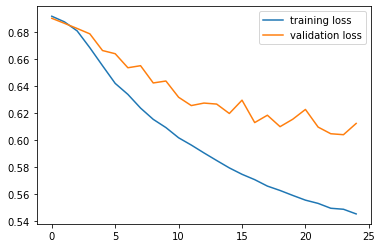

In [253]:
plt.plot(history.history['loss'],label = "training loss")
plt.plot(history.history['val_loss'], label = "validation loss")
plt.legend()
plt.show()

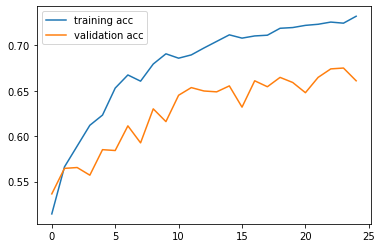

In [254]:
plt.plot(history.history['Acc'],label = "training acc")
plt.plot(history.history['val_Acc'], label = "validation acc")
plt.legend()
plt.show()

In [255]:
from sklearn.metrics import classification_report
# predict on test data
y_pred = model.predict(X_test_combined)
# get F1 score
print(classification_report(y_test, y_pred.round()))

              precision    recall  f1-score   support

         0.0       0.40      0.57      0.47       762
         1.0       0.85      0.73      0.78      2465

    accuracy                           0.69      3227
   macro avg       0.62      0.65      0.63      3227
weighted avg       0.74      0.69      0.71      3227



In [256]:
# get the f-1 score
from sklearn.metrics import f1_score
f1_score = f1_score(y_test, y_pred.round())
f1_score

0.7841601392515232

In [257]:
model.save("tensorflow.h5")